In [1]:
import numpy as np
import scipy as sc

from importlib import reload
from time import time
import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

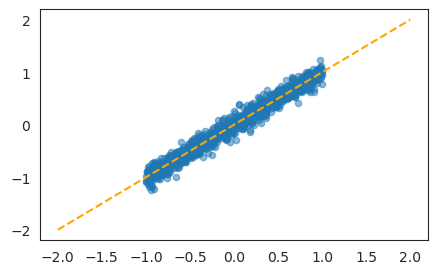

In [3]:
n = 1000
y_n = 2 * (np.random.rand(n) - 0.5)
f_n = get_f(y_n, off=0.1)
plt.figure(figsize=(5, 3))
plt.scatter(y_n, f_n, s=20, alpha=0.5);
plt.plot([-2, 2], [-2, 2], linestyle='--', c='orange');
plt.show()

In [358]:
# coverage of classical CI
ns = np.logspace(1, 3, 4)
N = 100000
q = 0.5
n_trial = 1000
alpha = 0.1

y_N = np.random.randn(N)
theta_star = get_quantile(y_N, q)
cov_nxt = np.zeros([ns.size, n_trial])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):
        
        y_n = np.random.randn(int(n))
        
        ci_cla = get_classical_ci(y_n, q, alpha)
        cov_nxt[n_idx, t] = theta_star >= ci_cla[0] and theta_star <= ci_cla[1]
np.mean(cov_nxt, axis=1)

array([0.933, 0.921, 0.899, 0.888])

In [323]:
# single trial of full PPI CI on quantile
n = 100
N = 10000
off = 0.1
q = 0.5
alpha = 0.1
delta = 0.01
B = np.max([q, 1 - q]) * 8  # TODO: definitely the root-N term that is the problem
# think about B? other alternatives?
quantile_lb = -10
quantile_ub = 10

y_n = np.random.randn(n)
y_N = np.random.randn(N)
f_n = get_f(y_n, off=off)
f_N = get_f(y_N, off=off)

print(get_quantile(y_N, q))
ci_pai = get_pai_ci(
    y_n, y_N, f_n, f_N, q, alpha, delta, B, quantile_lb, quantile_ub)
print(ci_pai)


0.014474833740071835
((-0.7975572543602234, 0.7997433748701658), 0.43493353333779905, 0.06520418111416608, 0.0877805556355506, 0.5465412634553638)


In [323]:
# single trial of full PPI CI on quantile
n = 100
N = 10000
off = 0.1
q = 0.5
alpha = 0.1
delta = 0.01
B = np.max([q, 1 - q]) * 8  # TODO: definitely the root-N term that is the problem
# think about B? other alternatives?
quantile_lb = -10
quantile_ub = 10

y_n = np.random.randn(n)
y_N = np.random.randn(N)
f_n = get_f(y_n, off=off)
f_N = get_f(y_N, off=off)

print(get_quantile(y_N, q))
ci_pai = get_pai_ci(
    y_n, y_N, f_n, f_N, q, alpha, delta, B, quantile_lb, quantile_ub)
print(ci_pai)


0.014474833740071835
((-0.7975572543602234, 0.7997433748701658), 0.43493353333779905, 0.06520418111416608, 0.0877805556355506, 0.5465412634553638)


In [ ]:
# compare classical and idealized PPI with exact rectifier
ns = np.logspace(1, 3, 1)
N = 1000000
off = 0.1
q = 0.5
quantile_lb = -10
quantile_ub = 10
n_trial = 100
alpha=0.1

cilen_nxtx2 = np.zeros([ns.size, n_trial, 2])
lr_nxt = np.zeros([ns.size, n_trial, 2])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):
        
        y_n = np.random.randn(int(n))
        y_N = np.random.randn(N)
        f_n = get_f(y_n, off=off)
        f_N = get_f(y_N, off=off)
        ci_pai, loss_imputed, rect, loss_ub = get_pai_ci_with_rectifier(
            y_n, y_N, f_n, f_N, q, quantile_lb, quantile_ub)
        ci_cla = get_classical_ci(y_n, q, alpha)
        cilen_nxtx2[n_idx, t] = ci_pai[1] - ci_pai[0], ci_cla[1] - ci_cla[0]
        lr_nxt[n_idx, t] = loss_imputed, rect
    print('done with {}'.format(n))

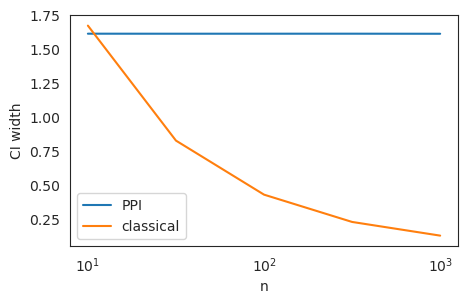

In [335]:
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 0], axis=1), label='PPI')
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 1], axis=1), label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.show()

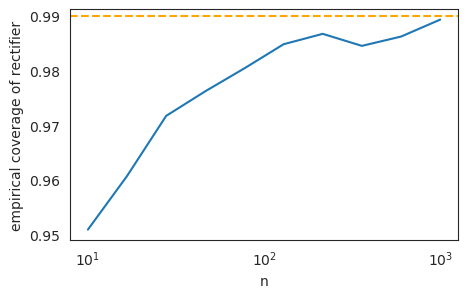

In [294]:
# sanity-check CLT UB on rectifier
ns = np.logspace(1, 3, 10)
N = 1000000
off = 0.5
q = 0.5
delta = 0.01
n_trial = 10000

y_N = np.random.randn(N)
f_N = get_f(y_N, off=off)
rect = np.mean(np.abs(y_N - f_N)) * np.max([q, 1 - q])

cov_nxt = np.zeros([ns.size, n_trial])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):

        y_n = np.random.randn(int(n))
        f_n = get_f(y_n, off=off)

        absdiff_n = np.abs(y_n - f_n)
        mu = np.mean(absdiff_n)
        sigma = np.std(absdiff_n, ddof=1)
        z = sc.stats.norm.ppf(1 - delta, loc=0, scale=1)
        rect_ub = np.max([q, 1 - q]) * (mu + z * sigma / np.sqrt(n))

        cov_nxt[n_idx, t] = rect <= rect_ub
        
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cov_nxt, axis=1));
plt.xscale('log');
plt.xlabel('n');
plt.ylabel('empirical coverage of rectifier');
plt.axhline(1 - delta, linestyle='--', c='orange')
plt.show()

## show looseness from moving sup inside sum

0.15613708756901082


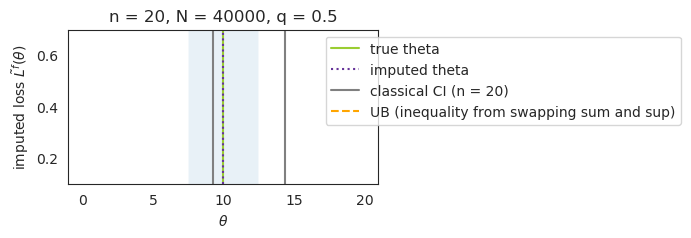

In [124]:
n = 20
N = 40000
q = 0.5
alpha = 0.1
y_scale = 20
label_noise_std = 0.4
thetas = np.arange(0, 20, 0.1)

y_n = y_scale * np.random.rand(n) 
y_N = y_scale * np.random.rand(N)
f_N = get_f(y_N, label_noise_std, 0, y_scale) 

loss_theta = np.array([np.mean(utils.pinball_loss(f_N, theta, q)) for theta in thetas])

# imputed quantities
theta_imputed = utils.get_quantile(f_N, q)
rect = np.mean(utils.get_quantile_rectifier(y_N, f_N, theta_imputed))
print(rect)
loss_imputed = np.mean(utils.pinball_loss(f_N, theta_imputed, q))
idx = np.where(loss_theta <= loss_imputed + rect)[0]
ci_fromub = (thetas[np.min(idx)], thetas[np.max(idx)])

# true theta
theta_true = utils.get_quantile(y_N, q)

# classical CI
ci_cla, _, _ = utils.get_classical_ci(y_n, q, alpha, 0, y_scale)

plt.figure(figsize=(4, 2));
plt.plot(thetas, loss_theta);
plt.axvline(theta_true, c='yellowgreen', label='true theta')
plt.axvline(theta_imputed, c='rebeccapurple', label='imputed theta', linestyle=':')
plt.axvline(ci_cla[0], c='gray', label='classical CI (n = {})'.format(n))
plt.axvline(ci_cla[1], c='gray')
plt.axhline(loss_imputed + rect, c='orange', linestyle='--',
            label='UB (inequality from swapping sum and sup)')
plt.fill_betweenx(np.array([0.0, 0.7]), ci_fromub[0], ci_fromub[1], alpha=0.1)
plt.legend(bbox_to_anchor=(1, 0, 1, 1));
plt.ylim([0.1, 0.7])
# plt.xlim([-1.5, 1.5])
plt.xlabel(r'$\theta$');
plt.ylabel(r'imputed loss $\tilde{L}^f(\theta)$')
plt.title('n = {}, N = {}, q = {}'.format(n, N, q))
plt.show();

## population target version

In [4]:
def get_f(y_, off, predmin, predmax):
    raw = y_ + off * np.random.randn(y_.size)
    out = np.fmax(raw, predmin)
    return np.fmin(out, predmax)

1.6815726589147084


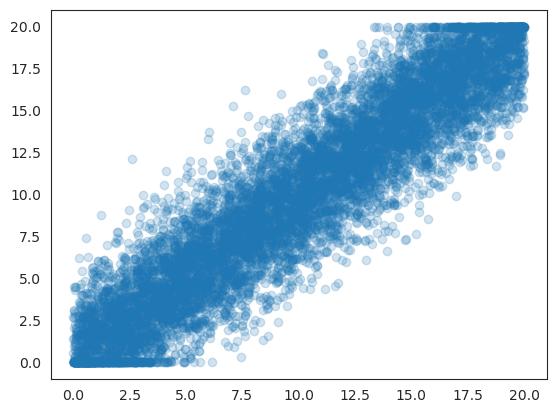

In [4]:
N = 10000
y_scale = 20
predmin = 0
predmax = 20
off = 2.3
y_N = y_scale * np.random.rand(N)
f_N = get_f(y_N, off, predmin, predmax)
plt.scatter(y_N, f_N, alpha=0.2)
print(np.mean(np.abs(f_N - y_N)))
plt.show()

In [18]:
# compare classical and PP CIs
reload(utils);
ns = np.array([10, 20, 40, 80, 160])
N = 10000
ymin = 0
ymax = 20
B = ymax
off = 0.1
q = 0.5
n_trial = 100
alpha = 0.1
delta1 = 0.08  # root-n term
delta2 = 0.01   # hoeffding

cilen_nxtx2 = np.zeros([ns.size, n_trial, 2])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):
        
        y_n = y_scale * np.random.rand(int(n))
        y_N = y_scale * np.random.rand(N)
        f_n = get_f(y_n, off, ymin, ymax)
        f_N = get_f(y_N, off, ymin, ymax)
        
        ci_pp, rect_ub, hoeffding_ub = utils.get_pp_ci(
            y_n, f_n, f_N, q, alpha, delta1, delta2, B, ymin, ymax)
        
        ci_cl, _, _ = utils.get_classical_ci(y_n, q, alpha)
        cilen_nxtx2[n_idx, t] = ci_pp[1] - ci_pp[0], ci_cl[1] - ci_cl[0]
    print('done with {}'.format(n))

done with 10
done with 20
done with 40
done with 80
done with 160


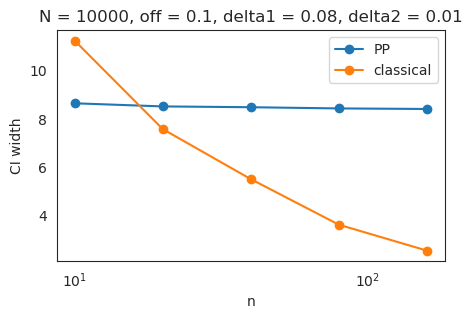

In [19]:
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 0], axis=1), '-o', label='PP')
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 1], axis=1), '-o', label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.title('N = {}, off = {}, delta1 = {}, delta2 = {}'.format(N, off, delta1, delta2))
plt.show()

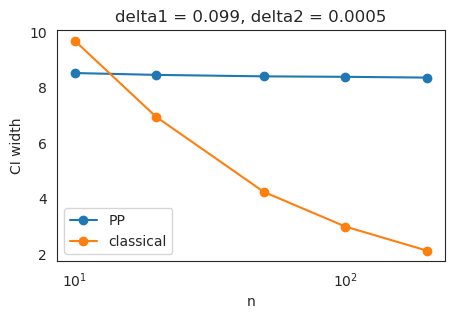

In [165]:
# this cell and below are with off = 0.1
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 0], axis=1), '-o', label='PP')
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 1], axis=1), '-o', label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.title('delta1 = {}, delta2 = {}'.format(delta1, delta2))
plt.show()

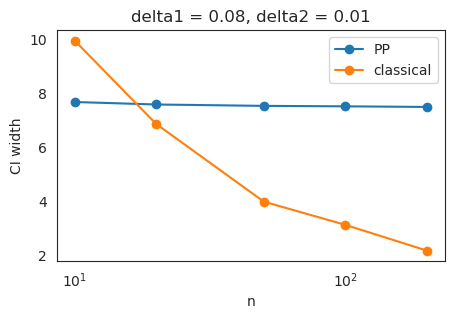

In [163]:
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 0], axis=1), '-o', label='PP')
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 1], axis=1), '-o', label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.title('delta1 = {}, delta2 = {}'.format(delta1, delta2))
plt.show()

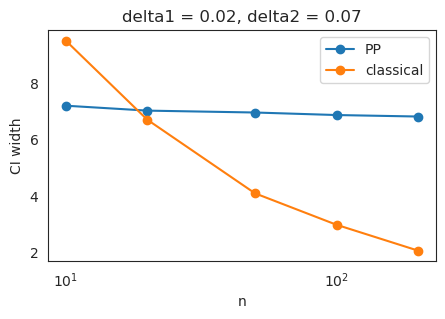

In [167]:
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 0], axis=1), '-o', label='PP')
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 1], axis=1), '-o', label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.title('delta1 = {}, delta2 = {}'.format(delta1, delta2))
plt.show()

## derive rectifier value one would need to beat classical CI

In [68]:
reload(utils)
n = 10
N = 40000
ymin = 0
ymax = 20
B = ymax
f_err_std = 1.5
q = 0.5
n_trial = 10
alpha = 0.1

# find q_l and q_u, which account for variation of N data points from population
# (just need N dummy values)
_, l, u = utils.get_classical_ci(np.zeros([N]), q, alpha, ymin, ymax)
ql = float(l) / N
qu = float(u) / N
print('ql = {:.3f}, qu = {:.3f}'.format(ql, qu))

y_N = y_scale * np.random.rand(N)
f_N = get_f(y_N, f_err_std, ymin, ymax)
q_imputed = utils.get_quantile(f_N, q)
print('true quantile: {:.3f}. imputed quantile: {:.3f}'.format(
    utils.get_quantile(y_N, q), q_imputed))


# imputed
thetal_imputed = utils.get_quantile(f_N, ql)
loss_thetal_imputed = np.mean(utils.pinball_loss(f_N, thetal_imputed, ql))
rectl = np.mean(utils.get_quantile_rectifier(y_N, f_N, thetal_imputed))
thetau_imputed = utils.get_quantile(f_N, qu)
loss_thetau_imputed = np.mean(utils.pinball_loss(f_N, thetau_imputed, qu))
rectu = np.mean(utils.get_quantile_rectifier(y_N, f_N, thetau_imputed))

print('thetal_imputed = {:.3f}, thetau_imputed = {:.3f}'.format(thetal_imputed, thetau_imputed))
print('low rectifier (based on N): {:.3f}'.format(rectl))
print('high rectifier (based on N): {:.3f}'.format(rectu))
print('loss_thetal_imputed = {:.3f}, loss_thetau_imputed = {:.3f}'.format(loss_thetal_imputed, loss_thetau_imputed))
print('imputed loss + rectifier for low: {:.3f}, high: {:.3f}'.format(
    loss_thetal_imputed + rectl, loss_thetau_imputed + rectu))
print()

cilen_nxtx2 = np.zeros([ns.size, n_trial, 2])
for t in range(n_trial):
        
    y_n = y_scale * np.random.rand(n)
    (thetal_cl, thetau_cl), _, _ = utils.get_classical_ci(y_n, q, alpha, ymin, ymax)
    
    loss_thetal_cl = np.mean(utils.pinball_loss(f_N, thetal_cl, ql))
    loss_thetau_cl = np.mean(utils.pinball_loss(f_N, thetau_cl, qu))
    print('classical: {:.3f}, {:.3f}. loss_thetal_cl = {:.3f}, loss_thetau_cl = {:.3f}'.format(
        thetal_cl, thetau_cl, loss_thetal_cl, loss_thetau_cl))
    print()





ql = 0.496, qu = 0.504
true quantile: 9.981. imputed quantile: 9.976
thetal_imputed = 9.886, thetau_imputed = 10.069
low rectifier (based on N): 0.546
high rectifier (based on N): 0.546
loss_thetal_imputed = 2.526, loss_thetau_imputed = 2.526
imputed loss + rectifier for low: 3.072, high: 3.072

classical: 3.760, 10.822. loss_thetal_cl = 3.473, loss_thetau_cl = 2.540

classical: 5.289, 14.935. loss_thetal_cl = 3.059, loss_thetau_cl = 3.114

classical: 5.056, 13.261. loss_thetal_cl = 3.115, loss_thetau_cl = 2.779

classical: 5.775, 12.811. loss_thetal_cl = 2.952, loss_thetau_cl = 2.713

classical: 3.925, 14.520. loss_thetal_cl = 3.423, loss_thetau_cl = 3.018

classical: 4.412, 12.066. loss_thetal_cl = 3.283, loss_thetau_cl = 2.624

classical: 6.452, 13.142. loss_thetal_cl = 2.823, loss_thetau_cl = 2.761

classical: 3.909, 13.612. loss_thetal_cl = 3.428, loss_thetau_cl = 2.838

classical: 5.788, 13.728. loss_thetal_cl = 2.950, loss_thetau_cl = 2.859

classical: 1.813, 11.940. loss_thetal

## verify loss decomposition

true quantile: 10.081. imputed quantile: 10.084
loss on true: 2.502073, loss on imputed: 2.502073
lftrue_lytrue = 0.003, lytrue_lyimputed = -0.000000, lyimputed_lfimputed = -0.003
True
lftrue_lytrue + lyimputed_lfimputed = 2.335502649053467e-07 (RECTIIFIER WANTS TO BE THIS)
rectifier: 0.19320596320607783
loss on true: 2.502073, loss on imputed + rectifier: 2.695279


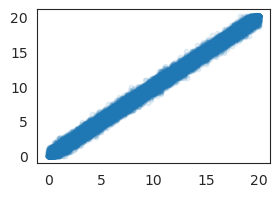

In [9]:
reload(utils)
N = 30000
ymin = 0
ymax = 20
B = ymax
f_err_std = 0.5
q = 0.5
alpha = 0.1

y_N = ymax * np.random.rand(N)
f_N = get_f(y_N, f_err_std, ymin, ymax)
theta_true = utils.get_quantile(y_N, q)
theta_imputed = utils.get_quantile(f_N, q)
print('true quantile: {:.3f}. imputed quantile: {:.3f}'.format(theta_imputed, theta_true))

lossf_true = np.mean(utils.pinball_loss(f_N, theta_true, q))
lossf_imputed = np.mean(utils.pinball_loss(f_N, theta_imputed, q))
print('loss on true: {:.6f}, loss on imputed: {:.6f}'.format(lossf_true, lossf_imputed))

lossy_true = np.mean(utils.pinball_loss(y_N, theta_true, q))
lossy_imputed = np.mean(utils.pinball_loss(y_N, theta_imputed, q))

lftrue_lytrue = lossf_true -  lossy_true
lytrue_lyimputed = lossy_true - lossy_imputed
lyimputed_lfimputed = lossy_imputed - lossf_imputed
print('lftrue_lytrue = {:.3f}, lytrue_lyimputed = {:.6f}, lyimputed_lfimputed = {:.3f}'.format(
    lftrue_lytrue, lytrue_lyimputed, lyimputed_lfimputed))

print(lossf_true == lftrue_lytrue + lytrue_lyimputed + lyimputed_lfimputed + lossf_imputed)
print('lftrue_lytrue + lyimputed_lfimputed = {} (RECTIIFIER WANTS TO BE THIS)'.format(lftrue_lytrue + lyimputed_lfimputed))

rect_n = utils.get_quantile_rectifier(y_N, f_N, theta_imputed)
rect = np.mean(rect_n)
# rect = utils.get_quantile_rectifier(y_N, f_N, theta_imputed)
print('rectifier: {}'.format(rect))
print('loss on true: {:.6f}, loss on imputed + rectifier: {:.6f}'.format(lossf_true, lossf_imputed + rect))

plt.figure(figsize=(3, 2))
plt.scatter(y_N, f_N, s=10, alpha=0.1)
plt.show()

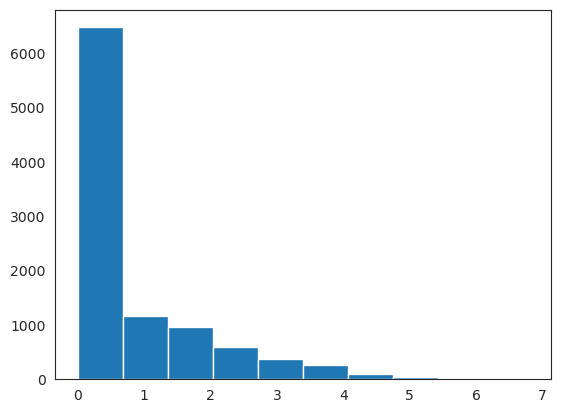

In [151]:
plt.hist(rect_n)
plt.show()